In [10]:
import os
import gc
import sys
import numpy as np
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
# from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

import matplotlib.pyplot as plt
import IPython.display as ipd

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 1) # set default size of plots


In [11]:
if torch.cuda.is_available():
            print('CUDA available')
            print(torch.cuda.get_device_name(0))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
            
else:
    print('WARNING: CUDA is not available')

CUDA available
NVIDIA GeForce RTX 3060 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    4.8 GB


In [12]:
# Global Vars

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "./Data/genres_original/"
csv_3 = "./Data/features_3_sec.csv"
csv_30 = "./Data/features_30_sec.csv"

audio_paths = [f for f in Path(path).glob('*\*.wav')]

batch_size = 32
num_workers = 0
epochs = 100

validation_split = .2

print(audio_paths[:10])

[WindowsPath('Data/genres_original/blues/blues.00000.wav'), WindowsPath('Data/genres_original/blues/blues.00001.wav'), WindowsPath('Data/genres_original/blues/blues.00002.wav'), WindowsPath('Data/genres_original/blues/blues.00003.wav'), WindowsPath('Data/genres_original/blues/blues.00004.wav'), WindowsPath('Data/genres_original/blues/blues.00005.wav'), WindowsPath('Data/genres_original/blues/blues.00006.wav'), WindowsPath('Data/genres_original/blues/blues.00007.wav'), WindowsPath('Data/genres_original/blues/blues.00008.wav'), WindowsPath('Data/genres_original/blues/blues.00009.wav')]


In [13]:
# Local Dataset
# data = DataLoader(path, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# get class mapping
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, class_dict = find_classes(path)

print(classes, list(class_dict.items())[:10])

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'] [('blues', 0), ('classical', 1), ('country', 2), ('disco', 3), ('hiphop', 4), ('jazz', 5), ('metal', 6), ('pop', 7), ('reggae', 8), ('rock', 9)]


In [14]:
# Dataset
# Data in the Models folder containts 100 audio samples per class
# This function splits audio into 80/20 train and test splits
class GTZAN(Dataset):
        def __init__(self, paths: list, transform=None):
                self.paths = paths
                self.transform = transform
        
        def __len__(self):
                return len(self.paths)

        def __getitem__(self, index):              
                signal, sr = torchaudio.load(self.paths[index])
                if self.transform:
                        signal = self.transform(signal)
                label = self.paths[index].__str__().split('\\')[2]
                return signal, label        

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [torch.tensor(class_dict[label])]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets               

test_paths = []
train_paths = []
for genre in classes:
        # get list of audio files in that genre
        samples = [f for f in Path(path).glob(f'*\{genre}.*.wav')]

        # Split list 80:20
        trainlist = samples[:80] # first 80
        testlist = samples[80:] 
        test_paths.extend(testlist)
        train_paths.extend(trainlist)

transform = torchaudio.transforms.Resample()

train_set = GTZAN(train_paths)
test_set = GTZAN(test_paths)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers, collate_fn=collate_fn)


Shape of waveform: torch.Size([1, 661794])


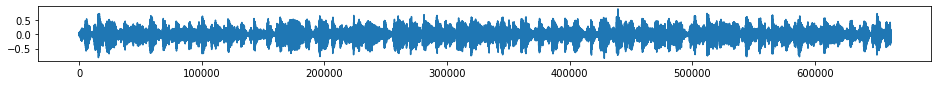

In [15]:
# visualise one audio sample
sample = train_set[0][0]
print("Shape of waveform: {}".format(train_set[0][0].size()))
plt.plot(sample.t().numpy())

In [16]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=10, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


input_size = train_set[0][0].shape[0]
model = M5(n_input=input_size, n_output=len(classes))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=10, bias=True)
)
Numbe

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

def train(model, epoch, log_interval):
    model.train()
    best_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)
        if loss.item() > best_loss:
            best_loss = loss.item()
            torch.save({
                    'epoch': epoch + 1,
                    'arch': 'CNN',
                    'state_dict': model.state_dict(),
                    'optimizer' : optimizer.state_dict(),
                    'scheduler' : scheduler.state_dict()
                }, f'./cnn.pth.tar')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [18]:
log_interval = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=epochs) as pbar:
    for epoch in range(1, epochs + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0.03125/100 [00:00<21:32, 12.93s/it]

Train Epoch: 1 [0/800 (0%)]	Loss: 2.428502


  1%|          | 0.65625/100 [00:05<15:21,  9.27s/it]

Train Epoch: 1 [640/800 (80%)]	Loss: 1.672428


  1%|          | 1.03125/100 [00:08<10:12,  6.18s/it]


Test Epoch: 1	Accuracy: 50/200 (25%)

Train Epoch: 2 [0/800 (0%)]	Loss: 1.570912


  2%|▏         | 1.71875/100 [00:11<05:15,  3.21s/it]

Train Epoch: 2 [640/800 (80%)]	Loss: 1.355948


  2%|▏         | 2.03125/100 [00:12<04:11,  2.57s/it]


Test Epoch: 2	Accuracy: 64/200 (32%)

Train Epoch: 3 [0/800 (0%)]	Loss: 1.462968


  3%|▎         | 2.65625/100 [00:14<05:31,  3.41s/it]

Train Epoch: 3 [640/800 (80%)]	Loss: 1.301001


  3%|▎         | 3.0625/100 [00:15<04:27,  2.76s/it] 


Test Epoch: 3	Accuracy: 65/200 (32%)

Train Epoch: 4 [0/800 (0%)]	Loss: 1.253569


  4%|▎         | 3.6875/100 [00:17<05:05,  3.18s/it] 

Train Epoch: 4 [640/800 (80%)]	Loss: 1.771440


  4%|▍         | 4.0625/100 [00:18<04:20,  2.71s/it]


Test Epoch: 4	Accuracy: 86/200 (43%)

Train Epoch: 5 [0/800 (0%)]	Loss: 1.244702


  5%|▍         | 4.6875/100 [00:20<05:02,  3.17s/it] 

Train Epoch: 5 [640/800 (80%)]	Loss: 1.282343


  5%|▌         | 5.0/100 [00:21<04:00,  2.54s/it]   


Test Epoch: 5	Accuracy: 87/200 (44%)

Train Epoch: 6 [0/800 (0%)]	Loss: 1.133682


  6%|▌         | 5.6875/100 [00:23<04:56,  3.15s/it] 

Train Epoch: 6 [640/800 (80%)]	Loss: 1.010025


  6%|▌         | 6.0625/100 [00:24<04:15,  2.72s/it]


Test Epoch: 6	Accuracy: 53/200 (26%)

Train Epoch: 7 [0/800 (0%)]	Loss: 0.878839


  7%|▋         | 6.65625/100 [00:26<05:18,  3.41s/it]

Train Epoch: 7 [640/800 (80%)]	Loss: 1.201812


  7%|▋         | 7.03125/100 [00:28<04:07,  2.66s/it]


Test Epoch: 7	Accuracy: 82/200 (41%)

Train Epoch: 8 [0/800 (0%)]	Loss: 0.793393


  8%|▊         | 7.71875/100 [00:30<05:25,  3.52s/it]

Train Epoch: 8 [640/800 (80%)]	Loss: 1.185743


  8%|▊         | 8.03125/100 [00:31<04:05,  2.67s/it]


Test Epoch: 8	Accuracy: 62/200 (31%)

Train Epoch: 9 [0/800 (0%)]	Loss: 1.009011


  9%|▊         | 8.71875/100 [00:33<04:59,  3.28s/it]

Train Epoch: 9 [640/800 (80%)]	Loss: 1.084779


  9%|▉         | 9.03125/100 [00:34<03:59,  2.63s/it]


Test Epoch: 9	Accuracy: 89/200 (44%)

Train Epoch: 10 [0/800 (0%)]	Loss: 0.846825


 10%|▉         | 9.71875/100 [00:36<04:47,  3.18s/it]

Train Epoch: 10 [640/800 (80%)]	Loss: 0.952444


 10%|█         | 10.03125/100 [00:37<03:55,  2.62s/it]


Test Epoch: 10	Accuracy: 85/200 (42%)

Train Epoch: 11 [0/800 (0%)]	Loss: 1.329429


 11%|█         | 10.65625/100 [00:39<05:50,  3.92s/it]

Train Epoch: 11 [640/800 (80%)]	Loss: 0.872043


 11%|█         | 11.03125/100 [00:40<03:56,  2.66s/it]


Test Epoch: 11	Accuracy: 91/200 (46%)

Train Epoch: 12 [0/800 (0%)]	Loss: 1.124888


 12%|█▏        | 11.71875/100 [00:43<05:20,  3.63s/it]

Train Epoch: 12 [640/800 (80%)]	Loss: 1.628852


 12%|█▏        | 12.03125/100 [00:43<03:57,  2.70s/it]


Test Epoch: 12	Accuracy: 64/200 (32%)

Train Epoch: 13 [0/800 (0%)]	Loss: 1.116398


 13%|█▎        | 12.71875/100 [00:46<04:37,  3.18s/it]

Train Epoch: 13 [640/800 (80%)]	Loss: 1.237448


 13%|█▎        | 13.03125/100 [00:46<03:49,  2.64s/it]


Test Epoch: 13	Accuracy: 98/200 (49%)

Train Epoch: 14 [0/800 (0%)]	Loss: 1.184655


 14%|█▎        | 13.6875/100 [00:49<04:36,  3.20s/it] 

Train Epoch: 14 [640/800 (80%)]	Loss: 1.253000


 14%|█▍        | 14.0625/100 [00:50<03:52,  2.71s/it]


Test Epoch: 14	Accuracy: 73/200 (36%)

Train Epoch: 15 [0/800 (0%)]	Loss: 1.001625


 15%|█▍        | 14.71875/100 [00:52<05:16,  3.72s/it]

Train Epoch: 15 [640/800 (80%)]	Loss: 1.571227


 15%|█▌        | 15.03125/100 [00:53<03:41,  2.61s/it]


Test Epoch: 15	Accuracy: 97/200 (48%)

Train Epoch: 16 [0/800 (0%)]	Loss: 1.009722


 16%|█▌        | 15.71875/100 [00:55<04:33,  3.24s/it]

Train Epoch: 16 [640/800 (80%)]	Loss: 0.971303


 16%|█▌        | 16.03125/100 [00:56<03:38,  2.60s/it]


Test Epoch: 16	Accuracy: 81/200 (40%)

Train Epoch: 17 [0/800 (0%)]	Loss: 0.629758


 17%|█▋        | 16.71875/100 [00:58<04:39,  3.35s/it]

Train Epoch: 17 [640/800 (80%)]	Loss: 0.770594


 17%|█▋        | 17.03125/100 [00:59<03:36,  2.60s/it]


Test Epoch: 17	Accuracy: 104/200 (52%)

Train Epoch: 18 [0/800 (0%)]	Loss: 0.788095


 18%|█▊        | 17.71875/100 [01:01<04:24,  3.21s/it]

Train Epoch: 18 [640/800 (80%)]	Loss: 0.959762


 18%|█▊        | 18.03125/100 [01:02<03:37,  2.65s/it]


Test Epoch: 18	Accuracy: 86/200 (43%)

Train Epoch: 19 [0/800 (0%)]	Loss: 0.857720


 19%|█▊        | 18.71875/100 [01:05<04:31,  3.34s/it]

Train Epoch: 19 [640/800 (80%)]	Loss: 1.201794


 19%|█▉        | 19.03125/100 [01:06<03:35,  2.67s/it]


Test Epoch: 19	Accuracy: 98/200 (49%)

Train Epoch: 20 [0/800 (0%)]	Loss: 0.863556


 20%|█▉        | 19.65625/100 [01:08<04:20,  3.24s/it]

Train Epoch: 20 [640/800 (80%)]	Loss: 0.843075


 20%|██        | 20.03125/100 [01:09<03:29,  2.62s/it]


Test Epoch: 20	Accuracy: 98/200 (49%)

Train Epoch: 21 [0/800 (0%)]	Loss: 0.900591


 21%|██        | 20.71875/100 [01:11<04:13,  3.19s/it]

Train Epoch: 21 [640/800 (80%)]	Loss: 0.652263


 21%|██        | 21.03125/100 [01:12<03:23,  2.58s/it]


Test Epoch: 21	Accuracy: 124/200 (62%)

Train Epoch: 22 [0/800 (0%)]	Loss: 0.649971


 22%|██▏       | 21.71875/100 [01:14<04:04,  3.12s/it]

Train Epoch: 22 [640/800 (80%)]	Loss: 0.464950


 22%|██▏       | 22.03125/100 [01:15<03:22,  2.60s/it]


Test Epoch: 22	Accuracy: 122/200 (61%)

Train Epoch: 23 [0/800 (0%)]	Loss: 0.629850


 23%|██▎       | 22.71875/100 [01:17<04:11,  3.25s/it]

Train Epoch: 23 [640/800 (80%)]	Loss: 0.390814


 23%|██▎       | 22.96875/100 [01:18<03:38,  2.84s/it]


Test Epoch: 23	Accuracy: 121/200 (60%)



 23%|██▎       | 23.03125/100 [01:18<04:12,  3.28s/it]

Train Epoch: 24 [0/800 (0%)]	Loss: 1.171118


 24%|██▎       | 23.71875/100 [01:20<04:01,  3.16s/it]

Train Epoch: 24 [640/800 (80%)]	Loss: 0.491136


 24%|██▍       | 24.03125/100 [01:21<03:18,  2.61s/it]


Test Epoch: 24	Accuracy: 123/200 (62%)

Train Epoch: 25 [0/800 (0%)]	Loss: 0.765757


 25%|██▍       | 24.71875/100 [01:24<03:58,  3.17s/it]

Train Epoch: 25 [640/800 (80%)]	Loss: 1.076449


 25%|██▌       | 25.03125/100 [01:24<03:14,  2.60s/it]


Test Epoch: 25	Accuracy: 122/200 (61%)

Train Epoch: 26 [0/800 (0%)]	Loss: 0.777133


 26%|██▌       | 25.65625/100 [01:26<04:11,  3.38s/it]

Train Epoch: 26 [640/800 (80%)]	Loss: 0.532882


 26%|██▌       | 26.0625/100 [01:28<03:28,  2.82s/it] 


Test Epoch: 26	Accuracy: 113/200 (56%)

Train Epoch: 27 [0/800 (0%)]	Loss: 0.785502


 27%|██▋       | 26.6875/100 [01:30<03:52,  3.18s/it]

Train Epoch: 27 [640/800 (80%)]	Loss: 0.684825


 27%|██▋       | 27.03125/100 [01:31<03:19,  2.74s/it]


Test Epoch: 27	Accuracy: 122/200 (61%)

Train Epoch: 28 [0/800 (0%)]	Loss: 0.327218


 28%|██▊       | 27.71875/100 [01:33<03:50,  3.19s/it]

Train Epoch: 28 [640/800 (80%)]	Loss: 0.554683


 28%|██▊       | 28.03125/100 [01:34<03:07,  2.60s/it]


Test Epoch: 28	Accuracy: 130/200 (65%)

Train Epoch: 29 [0/800 (0%)]	Loss: 0.617825


 29%|██▊       | 28.71875/100 [01:36<04:17,  3.62s/it]

Train Epoch: 29 [640/800 (80%)]	Loss: 0.297786


 29%|██▉       | 29.03125/100 [01:37<03:06,  2.62s/it]


Test Epoch: 29	Accuracy: 124/200 (62%)

Train Epoch: 30 [0/800 (0%)]	Loss: 0.630139


 30%|██▉       | 29.71875/100 [01:39<03:41,  3.16s/it]

Train Epoch: 30 [640/800 (80%)]	Loss: 0.635667


 30%|███       | 30.03125/100 [01:40<03:03,  2.63s/it]


Test Epoch: 30	Accuracy: 123/200 (62%)

Train Epoch: 31 [0/800 (0%)]	Loss: 0.626144


 31%|███       | 30.71875/100 [01:43<03:38,  3.15s/it]

Train Epoch: 31 [640/800 (80%)]	Loss: 0.412372


 31%|███       | 31.03125/100 [01:43<03:04,  2.67s/it]


Test Epoch: 31	Accuracy: 126/200 (63%)

Train Epoch: 32 [0/800 (0%)]	Loss: 0.443883


 32%|███▏      | 31.71875/100 [01:46<04:19,  3.80s/it]

Train Epoch: 32 [640/800 (80%)]	Loss: 0.470832


 32%|███▏      | 32.03125/100 [01:47<02:57,  2.62s/it]


Test Epoch: 32	Accuracy: 128/200 (64%)

Train Epoch: 33 [0/800 (0%)]	Loss: 0.667277


 33%|███▎      | 32.71875/100 [01:49<04:31,  4.04s/it]

Train Epoch: 33 [640/800 (80%)]	Loss: 1.082374


 33%|███▎      | 33.0625/100 [01:50<03:04,  2.75s/it] 


Test Epoch: 33	Accuracy: 122/200 (61%)

Train Epoch: 34 [0/800 (0%)]	Loss: 0.449075


 34%|███▎      | 33.71875/100 [01:52<03:38,  3.29s/it]

Train Epoch: 34 [640/800 (80%)]	Loss: 0.636888


 34%|███▍      | 34.03125/100 [01:53<02:54,  2.65s/it]


Test Epoch: 34	Accuracy: 130/200 (65%)

Train Epoch: 35 [0/800 (0%)]	Loss: 0.610259


 35%|███▍      | 34.71875/100 [01:56<03:27,  3.18s/it]

Train Epoch: 35 [640/800 (80%)]	Loss: 0.590764


 35%|███▌      | 35.03125/100 [01:56<02:48,  2.60s/it]


Test Epoch: 35	Accuracy: 123/200 (62%)

Train Epoch: 36 [0/800 (0%)]	Loss: 0.585569


 36%|███▌      | 35.71875/100 [01:59<03:35,  3.35s/it]

Train Epoch: 36 [640/800 (80%)]	Loss: 0.798504


 36%|███▌      | 36.03125/100 [02:00<02:52,  2.70s/it]


Test Epoch: 36	Accuracy: 131/200 (66%)

Train Epoch: 37 [0/800 (0%)]	Loss: 0.681599


 37%|███▋      | 36.65625/100 [02:02<03:39,  3.46s/it]

Train Epoch: 37 [640/800 (80%)]	Loss: 0.727683


 37%|███▋      | 37.03125/100 [02:03<02:51,  2.72s/it]


Test Epoch: 37	Accuracy: 120/200 (60%)

Train Epoch: 38 [0/800 (0%)]	Loss: 0.515401


 38%|███▊      | 37.65625/100 [02:05<03:38,  3.51s/it]

Train Epoch: 38 [640/800 (80%)]	Loss: 0.515683


 38%|███▊      | 38.03125/100 [02:06<02:45,  2.68s/it]


Test Epoch: 38	Accuracy: 129/200 (64%)

Train Epoch: 39 [0/800 (0%)]	Loss: 0.603759


 39%|███▊      | 38.71875/100 [02:09<03:38,  3.56s/it]

Train Epoch: 39 [640/800 (80%)]	Loss: 0.565937


 39%|███▉      | 39.0625/100 [02:10<02:50,  2.80s/it] 


Test Epoch: 39	Accuracy: 118/200 (59%)

Train Epoch: 40 [0/800 (0%)]	Loss: 0.343564


 40%|███▉      | 39.6875/100 [02:12<03:32,  3.52s/it] 

Train Epoch: 40 [640/800 (80%)]	Loss: 0.378702


 40%|████      | 40.0625/100 [02:13<02:46,  2.78s/it] 


Test Epoch: 40	Accuracy: 132/200 (66%)

Train Epoch: 41 [0/800 (0%)]	Loss: 0.451519


 41%|████      | 40.71875/100 [02:15<03:18,  3.34s/it]

Train Epoch: 41 [640/800 (80%)]	Loss: 0.380862


 41%|████      | 41.0625/100 [02:16<02:40,  2.72s/it] 


Test Epoch: 41	Accuracy: 130/200 (65%)

Train Epoch: 42 [0/800 (0%)]	Loss: 0.424088


 42%|████▏     | 41.71875/100 [02:18<03:09,  3.24s/it]

Train Epoch: 42 [640/800 (80%)]	Loss: 0.421866


 42%|████▏     | 42.03125/100 [02:19<02:34,  2.67s/it]


Test Epoch: 42	Accuracy: 133/200 (66%)

Train Epoch: 43 [0/800 (0%)]	Loss: 0.330072


 43%|████▎     | 42.71875/100 [02:22<03:12,  3.36s/it]

Train Epoch: 43 [640/800 (80%)]	Loss: 0.430270


 43%|████▎     | 43.0625/100 [02:23<02:34,  2.71s/it] 


Test Epoch: 43	Accuracy: 130/200 (65%)

Train Epoch: 44 [0/800 (0%)]	Loss: 0.486489


 44%|████▎     | 43.65625/100 [02:25<03:12,  3.41s/it]

Train Epoch: 44 [640/800 (80%)]	Loss: 0.399547


 44%|████▍     | 44.03125/100 [02:26<02:28,  2.66s/it]


Test Epoch: 44	Accuracy: 132/200 (66%)

Train Epoch: 45 [0/800 (0%)]	Loss: 0.522327


 45%|████▍     | 44.65625/100 [02:28<03:08,  3.41s/it]

Train Epoch: 45 [640/800 (80%)]	Loss: 0.478730


 45%|████▌     | 45.03125/100 [02:29<02:33,  2.79s/it]


Test Epoch: 45	Accuracy: 130/200 (65%)

Train Epoch: 46 [0/800 (0%)]	Loss: 0.411893


 46%|████▌     | 45.71875/100 [02:31<02:58,  3.30s/it]

Train Epoch: 46 [640/800 (80%)]	Loss: 0.574765


 46%|████▌     | 46.0625/100 [02:32<02:25,  2.70s/it] 


Test Epoch: 46	Accuracy: 129/200 (64%)

Train Epoch: 47 [0/800 (0%)]	Loss: 0.608701


 47%|████▋     | 46.65625/100 [02:34<02:59,  3.36s/it]

Train Epoch: 47 [640/800 (80%)]	Loss: 0.558072


 47%|████▋     | 47.03125/100 [02:36<02:15,  2.57s/it]


Test Epoch: 47	Accuracy: 130/200 (65%)

Train Epoch: 48 [0/800 (0%)]	Loss: 0.589902


 48%|████▊     | 47.71875/100 [02:38<02:56,  3.37s/it]

Train Epoch: 48 [640/800 (80%)]	Loss: 0.532085


 48%|████▊     | 48.03125/100 [02:39<02:15,  2.60s/it]


Test Epoch: 48	Accuracy: 134/200 (67%)

Train Epoch: 49 [0/800 (0%)]	Loss: 0.538405


 49%|████▊     | 48.71875/100 [02:41<02:50,  3.33s/it]

Train Epoch: 49 [640/800 (80%)]	Loss: 0.485877


 49%|████▉     | 49.0625/100 [02:42<02:18,  2.72s/it] 


Test Epoch: 49	Accuracy: 134/200 (67%)

Train Epoch: 50 [0/800 (0%)]	Loss: 0.556041


 50%|████▉     | 49.71875/100 [02:44<02:41,  3.20s/it]

Train Epoch: 50 [640/800 (80%)]	Loss: 0.462343


 50%|█████     | 50.03125/100 [02:45<02:09,  2.59s/it]


Test Epoch: 50	Accuracy: 132/200 (66%)

Train Epoch: 51 [0/800 (0%)]	Loss: 0.390412


 51%|█████     | 50.6875/100 [02:47<02:36,  3.18s/it] 

Train Epoch: 51 [640/800 (80%)]	Loss: 0.362568


 51%|█████     | 51.0625/100 [02:48<02:12,  2.71s/it]


Test Epoch: 51	Accuracy: 131/200 (66%)

Train Epoch: 52 [0/800 (0%)]	Loss: 0.433003


 52%|█████▏    | 51.6875/100 [02:50<02:35,  3.23s/it]

Train Epoch: 52 [640/800 (80%)]	Loss: 0.414890


 52%|█████▏    | 52.0625/100 [02:51<02:12,  2.76s/it] 


Test Epoch: 52	Accuracy: 130/200 (65%)

Train Epoch: 53 [0/800 (0%)]	Loss: 0.493831


 53%|█████▎    | 52.65625/100 [02:54<03:26,  4.36s/it]

Train Epoch: 53 [640/800 (80%)]	Loss: 1.273135


 53%|█████▎    | 53.03125/100 [02:55<02:04,  2.66s/it]


Test Epoch: 53	Accuracy: 129/200 (64%)

Train Epoch: 54 [0/800 (0%)]	Loss: 0.425846


 54%|█████▎    | 53.71875/100 [02:57<02:30,  3.25s/it]

Train Epoch: 54 [640/800 (80%)]	Loss: 0.617223


 54%|█████▍    | 54.03125/100 [02:58<02:01,  2.63s/it]


Test Epoch: 54	Accuracy: 133/200 (66%)

Train Epoch: 55 [0/800 (0%)]	Loss: 0.370176


 55%|█████▍    | 54.65625/100 [03:00<02:35,  3.43s/it]

Train Epoch: 55 [640/800 (80%)]	Loss: 0.780240


 55%|█████▌    | 55.03125/100 [03:01<01:57,  2.62s/it]


Test Epoch: 55	Accuracy: 133/200 (66%)

Train Epoch: 56 [0/800 (0%)]	Loss: 0.478564


 56%|█████▌    | 55.6875/100 [03:03<02:59,  4.04s/it] 

Train Epoch: 56 [640/800 (80%)]	Loss: 0.520319


 56%|█████▌    | 56.0625/100 [03:04<02:05,  2.85s/it] 


Test Epoch: 56	Accuracy: 132/200 (66%)

Train Epoch: 57 [0/800 (0%)]	Loss: 0.578634


 57%|█████▋    | 56.71875/100 [03:06<02:19,  3.21s/it]

Train Epoch: 57 [640/800 (80%)]	Loss: 0.381592


 57%|█████▋    | 57.03125/100 [03:07<01:53,  2.63s/it]


Test Epoch: 57	Accuracy: 132/200 (66%)

Train Epoch: 58 [0/800 (0%)]	Loss: 0.492797


 58%|█████▊    | 57.71875/100 [03:10<02:45,  3.91s/it]

Train Epoch: 58 [640/800 (80%)]	Loss: 1.063649


 58%|█████▊    | 57.96875/100 [03:11<02:07,  3.04s/it]


Test Epoch: 58	Accuracy: 132/200 (66%)



 58%|█████▊    | 58.09375/100 [03:11<02:17,  3.28s/it]

Train Epoch: 59 [0/800 (0%)]	Loss: 0.998376


 59%|█████▊    | 58.65625/100 [03:13<02:13,  3.24s/it]

Train Epoch: 59 [640/800 (80%)]	Loss: 0.485436


 59%|█████▉    | 59.03125/100 [03:14<01:46,  2.60s/it]


Test Epoch: 59	Accuracy: 131/200 (66%)

Train Epoch: 60 [0/800 (0%)]	Loss: 0.480476


 60%|█████▉    | 59.65625/100 [03:16<02:11,  3.25s/it]

Train Epoch: 60 [640/800 (80%)]	Loss: 0.509779


 60%|██████    | 60.03125/100 [03:17<01:48,  2.71s/it]


Test Epoch: 60	Accuracy: 132/200 (66%)

Train Epoch: 61 [0/800 (0%)]	Loss: 0.340905


 61%|██████    | 60.6875/100 [03:19<02:46,  4.25s/it] 

Train Epoch: 61 [640/800 (80%)]	Loss: 0.454780


 61%|██████    | 61.03125/100 [03:20<01:45,  2.71s/it]


Test Epoch: 61	Accuracy: 133/200 (66%)

Train Epoch: 62 [0/800 (0%)]	Loss: 0.380789


 62%|██████▏   | 61.71875/100 [03:23<02:03,  3.23s/it]

Train Epoch: 62 [640/800 (80%)]	Loss: 0.417758


 62%|██████▏   | 62.0/100 [03:23<01:36,  2.53s/it]    


Test Epoch: 62	Accuracy: 131/200 (66%)

Train Epoch: 63 [0/800 (0%)]	Loss: 0.511101


 63%|██████▎   | 62.71875/100 [03:26<02:11,  3.52s/it]

Train Epoch: 63 [640/800 (80%)]	Loss: 0.913830


 63%|██████▎   | 63.0625/100 [03:27<01:43,  2.80s/it] 


Test Epoch: 63	Accuracy: 134/200 (67%)

Train Epoch: 64 [0/800 (0%)]	Loss: 0.559110


 64%|██████▎   | 63.71875/100 [03:29<01:57,  3.25s/it]

Train Epoch: 64 [640/800 (80%)]	Loss: 0.461430


 64%|██████▍   | 64.03125/100 [03:30<01:38,  2.73s/it]


Test Epoch: 64	Accuracy: 130/200 (65%)

Train Epoch: 65 [0/800 (0%)]	Loss: 0.490158


 65%|██████▍   | 64.71875/100 [03:32<01:55,  3.26s/it]

Train Epoch: 65 [640/800 (80%)]	Loss: 0.436017


 65%|██████▌   | 65.0625/100 [03:33<01:38,  2.83s/it] 


Test Epoch: 65	Accuracy: 129/200 (64%)

Train Epoch: 66 [0/800 (0%)]	Loss: 0.243430


 66%|██████▌   | 65.71875/100 [03:36<02:03,  3.60s/it]

Train Epoch: 66 [640/800 (80%)]	Loss: 0.407571


 66%|██████▌   | 66.03125/100 [03:37<01:28,  2.60s/it]


Test Epoch: 66	Accuracy: 131/200 (66%)

Train Epoch: 67 [0/800 (0%)]	Loss: 0.553762


 67%|██████▋   | 66.71875/100 [03:39<01:52,  3.37s/it]

Train Epoch: 67 [640/800 (80%)]	Loss: 0.642961


 67%|██████▋   | 67.0625/100 [03:40<01:29,  2.71s/it] 


Test Epoch: 67	Accuracy: 131/200 (66%)

Train Epoch: 68 [0/800 (0%)]	Loss: 0.281097


 68%|██████▊   | 67.6875/100 [03:42<01:42,  3.18s/it] 

Train Epoch: 68 [640/800 (80%)]	Loss: 0.736046


 68%|██████▊   | 68.0625/100 [03:43<01:28,  2.76s/it]


Test Epoch: 68	Accuracy: 133/200 (66%)

Train Epoch: 69 [0/800 (0%)]	Loss: 0.261522


 69%|██████▊   | 68.71875/100 [03:45<01:42,  3.28s/it]

Train Epoch: 69 [640/800 (80%)]	Loss: 0.466184


 69%|██████▉   | 69.03125/100 [03:46<01:24,  2.73s/it]


Test Epoch: 69	Accuracy: 131/200 (66%)

Train Epoch: 70 [0/800 (0%)]	Loss: 0.420978


 70%|██████▉   | 69.6875/100 [03:48<01:42,  3.37s/it] 

Train Epoch: 70 [640/800 (80%)]	Loss: 0.583669


 70%|███████   | 70.03125/100 [03:50<01:22,  2.75s/it]


Test Epoch: 70	Accuracy: 128/200 (64%)

Train Epoch: 71 [0/800 (0%)]	Loss: 0.327163


 71%|███████   | 70.71875/100 [03:52<01:36,  3.31s/it]

Train Epoch: 71 [640/800 (80%)]	Loss: 0.379737


 71%|███████   | 71.03125/100 [03:53<01:15,  2.59s/it]


Test Epoch: 71	Accuracy: 133/200 (66%)

Train Epoch: 72 [0/800 (0%)]	Loss: 0.538773


 72%|███████▏  | 71.65625/100 [03:55<01:37,  3.44s/it]

Train Epoch: 72 [640/800 (80%)]	Loss: 0.325537


 72%|███████▏  | 72.0625/100 [03:56<01:16,  2.73s/it] 


Test Epoch: 72	Accuracy: 134/200 (67%)

Train Epoch: 73 [0/800 (0%)]	Loss: 0.343745


 73%|███████▎  | 72.65625/100 [03:58<01:33,  3.40s/it]

Train Epoch: 73 [640/800 (80%)]	Loss: 0.492016


 73%|███████▎  | 73.0/100 [03:59<01:07,  2.52s/it]    


Test Epoch: 73	Accuracy: 131/200 (66%)

Train Epoch: 74 [0/800 (0%)]	Loss: 0.341878


 74%|███████▎  | 73.65625/100 [04:01<01:32,  3.52s/it]

Train Epoch: 74 [640/800 (80%)]	Loss: 0.594509


 74%|███████▍  | 74.0/100 [04:02<01:10,  2.70s/it]    


Test Epoch: 74	Accuracy: 132/200 (66%)

Train Epoch: 75 [0/800 (0%)]	Loss: 0.570641


 75%|███████▍  | 74.71875/100 [04:05<01:27,  3.46s/it]

Train Epoch: 75 [640/800 (80%)]	Loss: 0.438593


 75%|███████▌  | 75.03125/100 [04:06<01:05,  2.61s/it]


Test Epoch: 75	Accuracy: 131/200 (66%)

Train Epoch: 76 [0/800 (0%)]	Loss: 0.527447


 76%|███████▌  | 75.6875/100 [04:08<01:29,  3.69s/it] 

Train Epoch: 76 [640/800 (80%)]	Loss: 0.687662


 76%|███████▌  | 76.0625/100 [04:09<01:05,  2.73s/it] 


Test Epoch: 76	Accuracy: 129/200 (64%)

Train Epoch: 77 [0/800 (0%)]	Loss: 0.613703


 77%|███████▋  | 76.6875/100 [04:11<01:24,  3.62s/it]

Train Epoch: 77 [640/800 (80%)]	Loss: 0.474841


 77%|███████▋  | 77.0625/100 [04:12<01:02,  2.74s/it] 


Test Epoch: 77	Accuracy: 130/200 (65%)

Train Epoch: 78 [0/800 (0%)]	Loss: 0.444342


 78%|███████▊  | 77.6875/100 [04:14<01:11,  3.19s/it] 

Train Epoch: 78 [640/800 (80%)]	Loss: 0.410824


 78%|███████▊  | 78.0625/100 [04:15<00:59,  2.71s/it]


Test Epoch: 78	Accuracy: 133/200 (66%)

Train Epoch: 79 [0/800 (0%)]	Loss: 0.622636


 79%|███████▊  | 78.71875/100 [04:18<01:09,  3.25s/it]

Train Epoch: 79 [640/800 (80%)]	Loss: 0.304430


 79%|███████▉  | 79.03125/100 [04:18<00:54,  2.59s/it]


Test Epoch: 79	Accuracy: 132/200 (66%)

Train Epoch: 80 [0/800 (0%)]	Loss: 0.302297


 80%|███████▉  | 79.71875/100 [04:21<01:04,  3.17s/it]

Train Epoch: 80 [640/800 (80%)]	Loss: 0.474991


 80%|████████  | 80.03125/100 [04:22<00:52,  2.62s/it]


Test Epoch: 80	Accuracy: 133/200 (66%)

Train Epoch: 81 [0/800 (0%)]	Loss: 0.418345


 81%|████████  | 80.71875/100 [04:24<01:00,  3.14s/it]

Train Epoch: 81 [640/800 (80%)]	Loss: 0.629791


 81%|████████  | 81.03125/100 [04:25<00:49,  2.59s/it]


Test Epoch: 81	Accuracy: 133/200 (66%)

Train Epoch: 82 [0/800 (0%)]	Loss: 0.433027


 82%|████████▏ | 81.71875/100 [04:27<00:57,  3.16s/it]

Train Epoch: 82 [640/800 (80%)]	Loss: 0.441391


 82%|████████▏ | 82.03125/100 [04:28<00:46,  2.59s/it]


Test Epoch: 82	Accuracy: 134/200 (67%)

Train Epoch: 83 [0/800 (0%)]	Loss: 0.578012


 83%|████████▎ | 82.71875/100 [04:30<00:54,  3.14s/it]

Train Epoch: 83 [640/800 (80%)]	Loss: 0.244580


 83%|████████▎ | 82.96875/100 [04:31<00:49,  2.92s/it]


Test Epoch: 83	Accuracy: 132/200 (66%)



 83%|████████▎ | 83.09375/100 [04:31<00:53,  3.18s/it]

Train Epoch: 84 [0/800 (0%)]	Loss: 1.515463


 84%|████████▎ | 83.71875/100 [04:33<00:51,  3.15s/it]

Train Epoch: 84 [640/800 (80%)]	Loss: 0.380574


 84%|████████▍ | 84.03125/100 [04:34<00:41,  2.61s/it]


Test Epoch: 84	Accuracy: 133/200 (66%)

Train Epoch: 85 [0/800 (0%)]	Loss: 0.610866


 85%|████████▍ | 84.65625/100 [04:36<00:49,  3.25s/it]

Train Epoch: 85 [640/800 (80%)]	Loss: 0.541466


 85%|████████▍ | 84.96875/100 [04:37<00:42,  2.86s/it]


Test Epoch: 85	Accuracy: 134/200 (67%)



 85%|████████▌ | 85.09375/100 [04:38<00:47,  3.15s/it]

Train Epoch: 86 [0/800 (0%)]	Loss: 0.981176


 86%|████████▌ | 85.71875/100 [04:40<00:45,  3.18s/it]

Train Epoch: 86 [640/800 (80%)]	Loss: 0.633409


 86%|████████▌ | 86.03125/100 [04:40<00:36,  2.62s/it]


Test Epoch: 86	Accuracy: 132/200 (66%)

Train Epoch: 87 [0/800 (0%)]	Loss: 0.521423


 87%|████████▋ | 86.71875/100 [04:43<00:43,  3.30s/it]

Train Epoch: 87 [640/800 (80%)]	Loss: 0.342064


 87%|████████▋ | 87.03125/100 [04:44<00:35,  2.72s/it]


Test Epoch: 87	Accuracy: 130/200 (65%)

Train Epoch: 88 [0/800 (0%)]	Loss: 0.676782


 88%|████████▊ | 87.71875/100 [04:46<00:40,  3.31s/it]

Train Epoch: 88 [640/800 (80%)]	Loss: 0.402366


 88%|████████▊ | 88.03125/100 [04:47<00:33,  2.79s/it]


Test Epoch: 88	Accuracy: 127/200 (64%)

Train Epoch: 89 [0/800 (0%)]	Loss: 0.481085


 89%|████████▊ | 88.65625/100 [04:49<00:38,  3.42s/it]

Train Epoch: 89 [640/800 (80%)]	Loss: 0.521358


 89%|████████▉ | 89.0625/100 [04:50<00:29,  2.71s/it] 


Test Epoch: 89	Accuracy: 133/200 (66%)

Train Epoch: 90 [0/800 (0%)]	Loss: 0.477468


 90%|████████▉ | 89.65625/100 [04:52<00:47,  4.63s/it]

Train Epoch: 90 [640/800 (80%)]	Loss: 0.913646


 90%|█████████ | 90.0625/100 [04:54<00:27,  2.73s/it] 


Test Epoch: 90	Accuracy: 131/200 (66%)

Train Epoch: 91 [0/800 (0%)]	Loss: 0.383099


 91%|█████████ | 90.6875/100 [04:56<00:29,  3.20s/it]

Train Epoch: 91 [640/800 (80%)]	Loss: 0.659491


 91%|█████████ | 91.0625/100 [04:57<00:25,  2.88s/it] 


Test Epoch: 91	Accuracy: 128/200 (64%)

Train Epoch: 92 [0/800 (0%)]	Loss: 0.342199


 92%|█████████▏| 91.71875/100 [04:59<00:26,  3.17s/it]

Train Epoch: 92 [640/800 (80%)]	Loss: 0.658349


 92%|█████████▏| 92.03125/100 [05:00<00:21,  2.65s/it]


Test Epoch: 92	Accuracy: 133/200 (66%)

Train Epoch: 93 [0/800 (0%)]	Loss: 0.448861


 93%|█████████▎| 92.65625/100 [05:02<00:26,  3.61s/it]

Train Epoch: 93 [640/800 (80%)]	Loss: 0.673815


 93%|█████████▎| 93.0625/100 [05:03<00:18,  2.70s/it] 


Test Epoch: 93	Accuracy: 132/200 (66%)

Train Epoch: 94 [0/800 (0%)]	Loss: 0.334231


 94%|█████████▎| 93.65625/100 [05:05<00:29,  4.68s/it]

Train Epoch: 94 [640/800 (80%)]	Loss: 1.134464


 94%|█████████▍| 94.0625/100 [05:07<00:16,  2.72s/it] 


Test Epoch: 94	Accuracy: 132/200 (66%)

Train Epoch: 95 [0/800 (0%)]	Loss: 0.242554


 95%|█████████▍| 94.71875/100 [05:09<00:17,  3.30s/it]

Train Epoch: 95 [640/800 (80%)]	Loss: 0.466206


 95%|█████████▌| 95.03125/100 [05:10<00:13,  2.73s/it]


Test Epoch: 95	Accuracy: 132/200 (66%)

Train Epoch: 96 [0/800 (0%)]	Loss: 0.308363


 96%|█████████▌| 95.71875/100 [05:12<00:14,  3.42s/it]

Train Epoch: 96 [640/800 (80%)]	Loss: 0.349256


 96%|█████████▌| 96.0/100 [05:13<00:10,  2.54s/it]    


Test Epoch: 96	Accuracy: 133/200 (66%)



 96%|█████████▌| 96.0625/100 [05:13<00:13,  3.33s/it]

Train Epoch: 97 [0/800 (0%)]	Loss: 1.122457


 97%|█████████▋| 96.6875/100 [05:15<00:10,  3.19s/it]

Train Epoch: 97 [640/800 (80%)]	Loss: 0.552538


 97%|█████████▋| 97.0625/100 [05:16<00:07,  2.69s/it]


Test Epoch: 97	Accuracy: 130/200 (65%)

Train Epoch: 98 [0/800 (0%)]	Loss: 0.655242


 98%|█████████▊| 97.71875/100 [05:18<00:08,  3.51s/it]

Train Epoch: 98 [640/800 (80%)]	Loss: 0.426449


 98%|█████████▊| 97.96875/100 [05:19<00:05,  2.88s/it]


Test Epoch: 98	Accuracy: 134/200 (67%)



 98%|█████████▊| 98.09375/100 [05:19<00:05,  3.15s/it]

Train Epoch: 99 [0/800 (0%)]	Loss: 1.057499


 99%|█████████▊| 98.71875/100 [05:21<00:04,  3.12s/it]

Train Epoch: 99 [640/800 (80%)]	Loss: 0.403150


 99%|█████████▉| 99.03125/100 [05:22<00:02,  2.69s/it]


Test Epoch: 99	Accuracy: 132/200 (66%)

Train Epoch: 100 [0/800 (0%)]	Loss: 0.301343


100%|█████████▉| 99.71875/100 [05:25<00:00,  3.20s/it]

Train Epoch: 100 [640/800 (80%)]	Loss: 0.563280


100%|██████████| 100.0/100 [05:25<00:00,  3.26s/it]   


Test Epoch: 100	Accuracy: 132/200 (66%)

